## Attempt to Fit and compare more complex CNNs with a skip blocks on 10000 training CFS4 images from both the 50x50 and 96x96 lattice. 
## the incremtal approch appears to have the effect  simmialr to block diagonal least squares. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import sys
import shutil
from shutil import copyfile, copy2
from shutil import move

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from scipy import stats
# Cause plots to be displayed in the notebook:
%matplotlib inline

In [4]:
import subprocess 

In [5]:
from matplotlib import cm
from latt2D_modules import calc_diffuse_cfs4,calc_diffuse_cfs4_big
from latt2D_modules import get_occ_map, get_2D_occ_map_from_seq,store_occ_map_as_seq
from latt2D_modules import plot_occ_map,read_bin,output_16bit_pgm
from CFS_CNN_models import construct_new_small_cfs_model
from CFS_CNN_models import construct_new_medium_cfs_model
from CFS_CNN_models import construct_new_large_cfs_model
import time

2023-05-14 07:36:29.892404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from aux_functions import model_evaluate_and_plot
from aux_functions import check_cfs_dist, prep_img_data
from aux_functions import regenerate_test_cfs_vector_and_compare
from aux_functions import regenerate_pred_cfs_vector_and_compare

In [7]:
from tensorflow import keras
from tensorflow.keras import layers


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import h5py
from keras.callbacks import ModelCheckpoint

#### Prep data

cfs4_img_data
         00        01        02        03        10        11        12  \
0  0.999997 -0.128003  0.379197  0.369597  0.070397  0.159997 -0.379203   
1  0.999690 -0.285110 -0.334710  0.180490 -0.008310  0.201290 -0.374710   
2  0.998335  0.036735  0.239935  0.411135 -0.177665 -0.011265 -0.044865   
3  0.999124 -0.210476  0.171924  0.219924  0.186324 -0.164076 -0.229676   
4  0.999948 -0.216052 -0.171252  0.271948 -0.096052  0.156748  0.243148   

         13        20        21        22        23        30        31  \
0  0.454397 -0.020803 -0.204803 -0.294403 -0.153603 -0.084803  0.454397   
1  0.236490 -0.502710 -0.085110  0.274890  0.082890  0.178890 -0.173110   
2  0.070335  0.311935  0.126335  0.486335 -0.091265 -0.228865 -0.329665   
3  0.264724  0.072724 -0.615276  0.187924 -0.255276 -0.317676 -0.138476   
4 -0.564852  0.235148 -0.116852  0.119948 -0.145652 -0.528052  0.398348   

         32        33  
0 -0.144003  0.283197  
1  0.294090 -0.257910  
2 -0.230465 

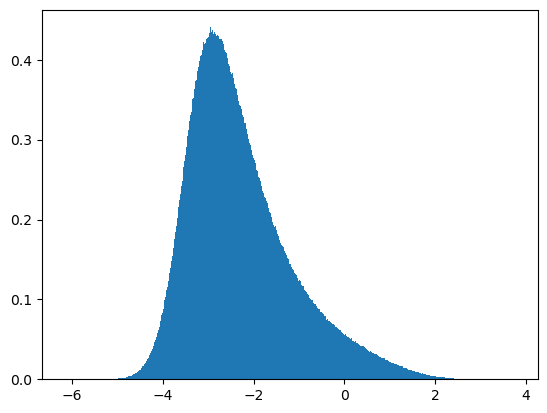

In [9]:
df1, X1, y1, X_train1, X_test1, y_train1, y_test1 = prep_img_data('cfs4_image_dataset_5000.h5', 'output_correlations_cfs4_5000.csv',cfs=4)

cfs4_big_bin_1
         00        01        02        03        10        11        12  \
0  0.999963 -0.194047  0.068539 -0.276947 -0.054724  0.128001  0.201352   
1  0.999635 -0.185695  0.109010 -0.193941  0.268299  0.111180 -0.179184   
2  0.999994 -0.059468 -0.047315 -0.403217  0.317703 -0.270839 -0.026915   
3  0.999999 -0.035591 -0.029949  0.048610 -0.033421  0.157985 -0.015192   
4  0.999852 -0.174627  0.422161  0.034141  0.417387 -0.653360  0.372248   

         13        20        21        22        23        30        31  \
0  0.152307  0.249963  0.212203 -0.180158 -0.223995 -0.130245  0.503869   
1 -0.441771  0.321250  0.242257  0.343819 -0.366684 -0.203490 -0.072847   
2 -0.567280 -0.298183 -0.128912 -0.287332 -0.198790 -0.332037  0.055116   
3 -0.733508  0.664495  0.013020  0.234808 -0.000001  0.099825  0.266926   
4 -0.203707 -0.070460 -0.676797  0.380929 -0.600408  0.142213 -0.163776   

         32        33  
0 -0.067311  0.144928  
1  0.324288 -0.449583  
2 -0.503044

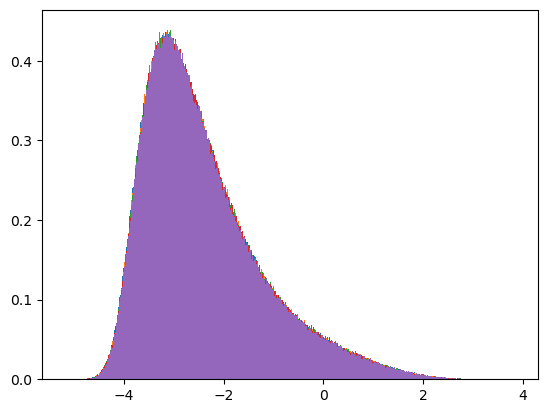

In [10]:
df3a, X3a, y3a, X_train3a, X_test3a, y_train3a, y_test3a = prep_img_data('cfs4_big_bin_1.h5', 'cfs4_big_corr_out_1.csv',cfs=4)
df3b, X3b, y3b, X_train3b, X_test3b, y_train3b, y_test3b = prep_img_data('cfs4_big_bin_2.h5', 'cfs4_big_corr_out_2.csv',cfs=4)
df3c, X3c, y3c, X_train3c, X_test3c, y_train3c, y_test3c = prep_img_data('cfs4_big_bin_3.h5', 'cfs4_big_corr_out_3.csv',cfs=4)
df3d, X3d, y3d, X_train3d, X_test3d, y_train3d, y_test3d = prep_img_data('cfs4_big_bin_4.h5', 'cfs4_big_corr_out_4.csv',cfs=4)
df3e, X3e, y3e, X_train3e, X_test3e, y_train3e, y_test3e = prep_img_data('cfs4_big_bin_5.h5', 'cfs4_big_corr_out_5.csv',cfs=4)

In [18]:
# merge X3 data and test train split

df3=pd.concat([df3a,df3b,df3c,df3d,df3e],axis=0)
X3=np.r_[X3a,X3b,X3c,X3d,X3e]
y3=np.r_[y3a,y3b,y3c,y3d,y3e]
print(np.shape(X3))
print(np.shape(y3))
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state=42,test_size=0.2)
X_train3=np.expand_dims(X_train3, -1)
X_test3=np.expand_dims(X_test3, -1)
df3.describe()

(5000, 64, 64)
(5000, 15)


,00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.999896,0.005883,0.017566,0.000441,-0.000299,0.001796,-0.003164,-0.005652,0.017299,-0.010500,0.016346,-0.008498,0.005189,0.004710,0.007113,0.001295
std,0.000149,0.254972,0.290085,0.339781,0.253247,0.268367,0.294918,0.326287,0.296402,0.292929,0.300561,0.316614,0.345127,0.326650,0.311847,0.302350
min,0.998623,-0.802295,-0.760125,-0.768232,-0.769818,-0.785087,-0.825625,-0.750517,-0.801652,-0.746623,-0.743059,-0.792969,-0.775306,-0.757150,-0.783427,-0.789584
25%,0.999863,-0.182756,-0.208882,-0.271270,-0.184823,-0.199713,-0.232348,-0.267608,-0.212570,-0.237422,-0.220496,-0.262316,-0.284770,-0.259702,-0.241030,-0.236783
50%,0.999952,0.004691,0.015333,0.001680,-0.001326,-0.000460,-0.004341,-0.003410,0.015176,-0.013140,0.010762,-0.007412,0.004496,0.004262,0.010348,0.001936
75%,0.999989,0.197781,0.238820,0.279063,0.184863,0.200305,0.227417,0.257547,0.248751,0.220568,0.259299,0.237806,0.287753,0.267818,0.254721,0.237926
max,1.000000,0.762976,0.796827,0.784665,0.766927,0.767356,0.747309,0.782935,0.776420,0.779512,0.821173,0.852862,0.730624,0.756456,0.758662,0.801789


### build models 

In [19]:
model_smX13=construct_new_small_cfs_model(15)

batch_size = 32
epochs = 100
# Define checkpoint callback
checkpoint = ModelCheckpoint('cfs4_sm_X13_incremental.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# opt = keras.optimizers.Adam(learning_rate=0.01) # not using this atm

# optionally Load  saved weights into the model
# model.load_weights('cfs4_sm_X3a.h5')

model_smX13.compile(loss="mse", optimizer="adam", metrics=[MeanSquaredError(),MeanAbsoluteError()])


2023-05-14 08:01:52.323371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 08:01:52.324562: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
#inital training on X1 data 
history_smX13_1 =model_smX13.fit(X_train1,y_train1,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])


Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 8.6740 - mean_squared_error: 8.6740 - mean_absolute_error: 2.1949
Epoch 1: val_loss improved from inf to 0.21605, saving model to cfs4_sm_X13_incremental.h5
100/100 [==============================] - 7s 66ms/step - loss: 8.6740 - mean_squared_error: 8.6740 - mean_absolute_error: 2.1949 - val_loss: 0.2161 - val_mean_squared_error: 0.2161 - val_mean_absolute_error: 0.3628
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.5473 - mean_squared_error: 4.5473 - mean_absolute_error: 1.6162
Epoch 2: val_loss did not improve from 0.21605
100/100 [==============================] - 6s 59ms/step - loss: 4.5473 - mean_squared_error: 4.5473 - mean_absolute_error: 1.6162 - val_loss: 0.2494 - val_mean_squared_error: 0.2494 - val_mean_absolute_error: 0.3921
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 3.0250 - mean_squared_error: 3.0250 - mean_absolute_error: 1.3254
Epoch 3: val_loss d

32/32 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0377
Loss: 0.0024337677750736475
Mean Square Error: 0.0024337677750736475
Mean Absolute Error: 0.03772435709834099
32/32 [==============================] - 1s 30ms/step
Test R2 score: 0.9734994762685091


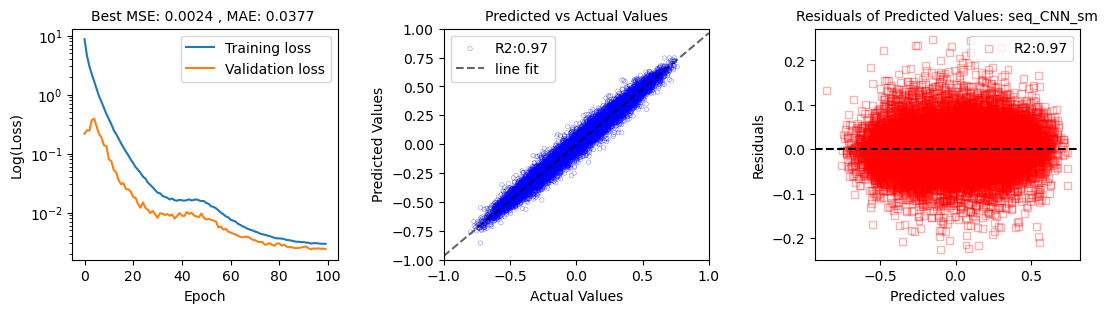

In [21]:
model_evaluate_and_plot(model_smX13,history_smX13_1,X_test1,y_test1)

In [22]:
# increment with trainings on X3a thru X3e 
history_smX13_2 =model_smX13.fit(X_train3a,y_train3a,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])
history_smX13_3 =model_smX13.fit(X_train3b,y_train3b,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])
history_smX13_4 =model_smX13.fit(X_train3c,y_train3c,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])
history_smX13_5 =model_smX13.fit(X_train3d,y_train3d,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])
history_smX13_6 =model_smX13.fit(X_train3e,y_train3e,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0293
Epoch 1: val_loss improved from 0.00240 to 0.00108, saving model to cfs4_sm_X13_incremental.h5
20/20 [==============================] - 1s 45ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0293 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0264
Epoch 2/100
19/20 [===========================>..] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0271
Epoch 2: val_loss improved from 0.00108 to 0.00105, saving model to cfs4_sm_X13_incremental.h5
20/20 [==============================] - 1s 33ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0270 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0259
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_

7/7 [==============================] - 0s 20ms/step - loss: 3.2780e-04 - mean_squared_error: 3.2780e-04 - mean_absolute_error: 0.0142
Loss: 0.00032780057517811656
Mean Square Error: 0.00032780057517811656
Mean Absolute Error: 0.014231895096600056
7/7 [==============================] - 0s 28ms/step
Test R2 score: 0.9962842664183523


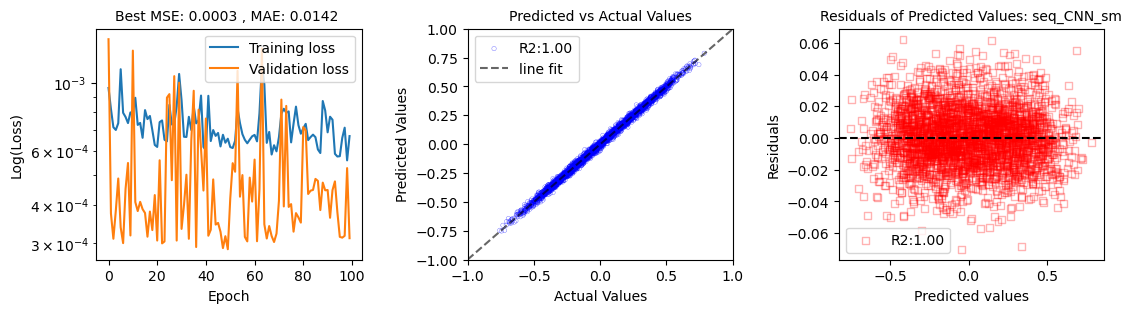

In [23]:
model_evaluate_and_plot(model_smX13,history_smX13_6,X_test3a,y_test3a)

32/32 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0395
Loss: 0.002588664647191763
Mean Square Error: 0.002588664647191763
Mean Absolute Error: 0.03954613581299782
32/32 [==============================] - 0s 7ms/step
Test R2 score: 0.9718128629552893


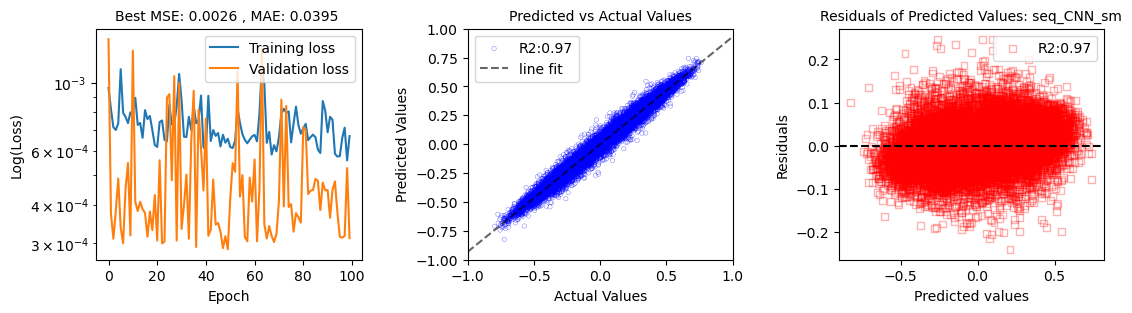

In [24]:
model_evaluate_and_plot(model_smX13,history_smX13_6,X_test1,y_test1)

32/32 [==============================] - 0s 8ms/step - loss: 3.0556e-04 - mean_squared_error: 3.0556e-04 - mean_absolute_error: 0.0135
Loss: 0.0003055608249269426
Mean Square Error: 0.0003055608249269426
Mean Absolute Error: 0.013524433597922325
32/32 [==============================] - 0s 7ms/step
Test R2 score: 0.9966398490410687


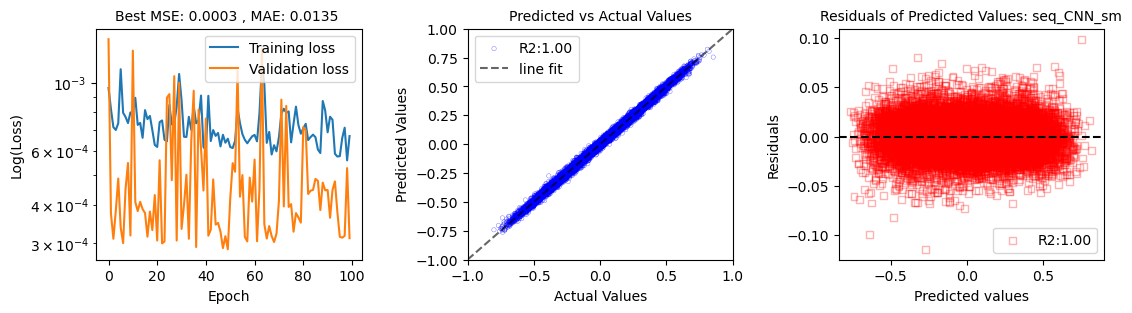

In [25]:
model_evaluate_and_plot(model_smX13,history_smX13_6,X_test3,y_test3)

### construct a medium sized model 

In [26]:
model_mdX13=construct_new_medium_cfs_model(15)

batch_size = 32
epochs = 100
# Define checkpoint callback
checkpoint = ModelCheckpoint('cfs4_md_X13.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# opt = keras.optimizers.Adam(learning_rate=0.01) # not using this atm
model_mdX13.compile(loss="mse", optimizer="adam", metrics=[MeanSquaredError(),MeanAbsoluteError()])

In [27]:
history_mdX13_1 =model_mdX13.fit(X_train1,y_train1,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.7350 - mean_squared_error: 1.7350 - mean_absolute_error: 0.9393
Epoch 1: val_loss improved from inf to 0.09124, saving model to cfs4_md_X13.h5
100/100 [==============================] - 7s 69ms/step - loss: 1.7350 - mean_squared_error: 1.7350 - mean_absolute_error: 0.9393 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - val_mean_absolute_error: 0.2353
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.8871 - mean_squared_error: 0.8871 - mean_absolute_error: 0.6775
Epoch 2: val_loss improved from 0.09124 to 0.05621, saving model to cfs4_md_X13.h5
100/100 [==============================] - 5s 51ms/step - loss: 0.8839 - mean_squared_error: 0.8839 - mean_absolute_error: 0.6764 - val_loss: 0.0562 - val_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.1867
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.5699 - mean_squared_error: 0.5699 - mean_absolute_error: 0.

32/32 [==============================] - 1s 36ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0494
Loss: 0.0038020540960133076
Mean Square Error: 0.0038020540960133076
Mean Absolute Error: 0.049385327845811844
32/32 [==============================] - 2s 45ms/step
Test R2 score: 0.958600655662461


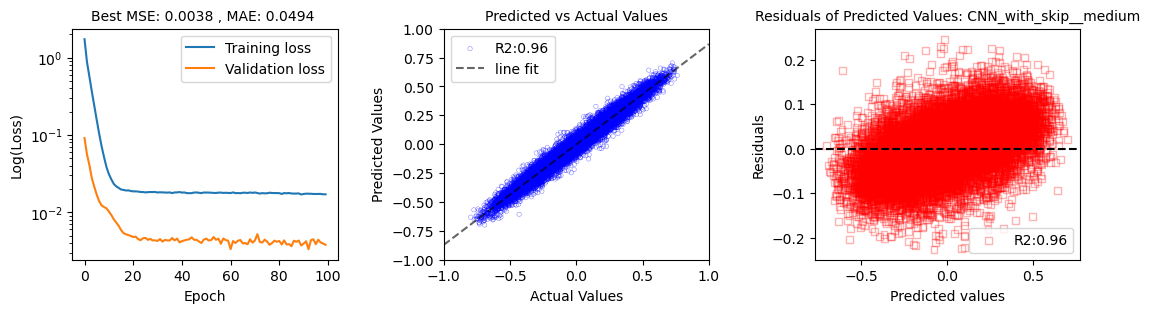

In [28]:
model_evaluate_and_plot(model_mdX13,history_mdX13_1,X_test1,y_test1)

In [29]:
history_mdX13_2 =model_mdX13.fit(X_train3,y_train3,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0998
Epoch 1: val_loss improved from 0.00332 to 0.00105, saving model to cfs4_md_X13.h5
100/100 [==============================] - 10s 105ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0998 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0254
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0996
Epoch 2: val_loss did not improve from 0.00105
100/100 [==============================] - 12s 122ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0996 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0282
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1006
Epoch 3: val_loss did n

32/32 [==============================] - 1s 33ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0322
Loss: 0.0015593955758959055
Mean Square Error: 0.0015593955758959055
Mean Absolute Error: 0.03219261020421982
32/32 [==============================] - 1s 35ms/step
Test R2 score: 0.9828518464958151


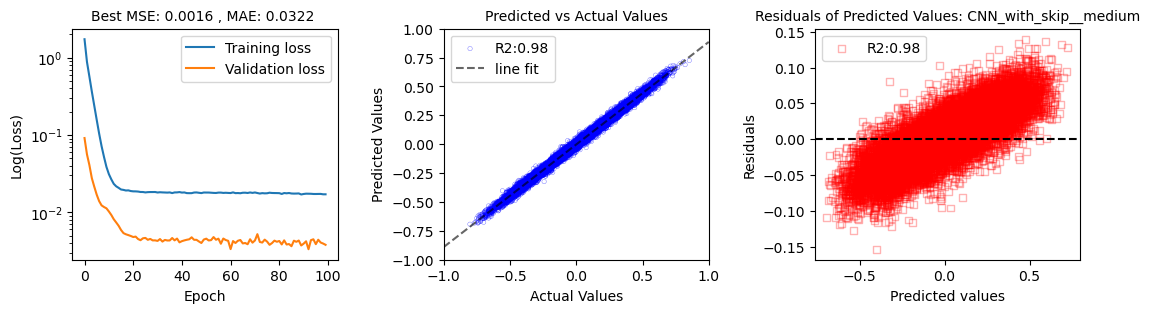

In [30]:
model_evaluate_and_plot(model_mdX13,history_mdX13_1,X_test3,y_test3)

## the above residual plot (res = obs - predicted ) has a positive slope indicating that the model is over estimating the magnitude of the predicted value but the sign of the value is correct. it is not clear yet if this can be fixed with the incremental training approch which is what was used for the small model

32/32 [==============================] - 1s 35ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0561
Loss: 0.004742598161101341
Mean Square Error: 0.004742598161101341
Mean Absolute Error: 0.05613566190004349
32/32 [==============================] - 1s 33ms/step
Test R2 score: 0.9483593617026547


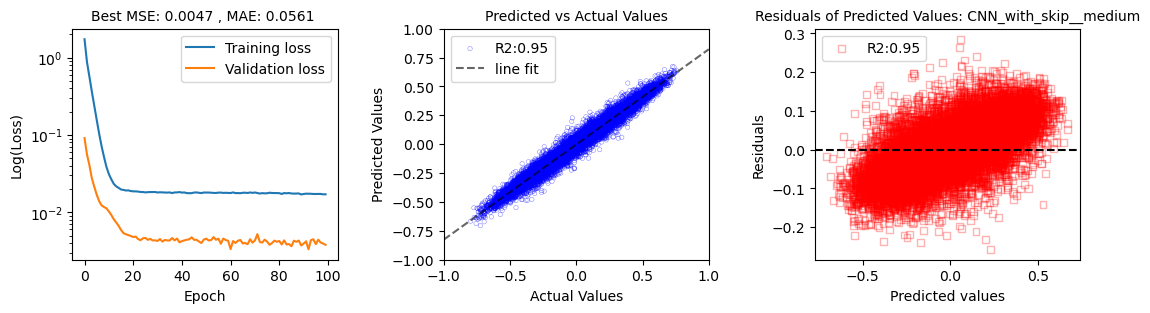

In [31]:
model_evaluate_and_plot(model_mdX13,history_mdX13_1,X_test1,y_test1)

### construct a large sized model 

In [34]:
model_lgX13=construct_new_large_cfs_model(15)

batch_size = 32
epochs = 100
# Define checkpoint callback
checkpoint = ModelCheckpoint('cfs4_lg_X13.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# opt = keras.optimizers.Adam(learning_rate=0.01) # not using this atm
model_lgX13.compile(loss="mse", optimizer="adam", metrics=[MeanSquaredError(),MeanAbsoluteError()])

In [35]:
history_lgX13_1 =model_lgX13.fit(X_train1,y_train1,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.5207 - mean_squared_error: 1.5207 - mean_absolute_error: 0.8382
Epoch 1: val_loss improved from inf to 0.10687, saving model to cfs4_lg_X13.h5
100/100 [==============================] - 31s 297ms/step - loss: 1.5207 - mean_squared_error: 1.5207 - mean_absolute_error: 0.8382 - val_loss: 0.1069 - val_mean_squared_error: 0.1069 - val_mean_absolute_error: 0.2626
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.8581 - mean_squared_error: 0.8581 - mean_absolute_error: 0.6078
Epoch 2: val_loss improved from 0.10687 to 0.09098, saving model to cfs4_lg_X13.h5
100/100 [==============================] - 29s 286ms/step - loss: 0.8581 - mean_squared_error: 0.8581 - mean_absolute_error: 0.6078 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - val_mean_absolute_error: 0.2471
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.5978 - mean_squared_error: 0.5978 - mean_absolute_error

32/32 [==============================] - 3s 83ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0525
Loss: 0.00435132160782814
Mean Square Error: 0.00435132160782814
Mean Absolute Error: 0.05247606709599495
32/32 [==============================] - 3s 84ms/step
Test R2 score: 0.9526198540099976


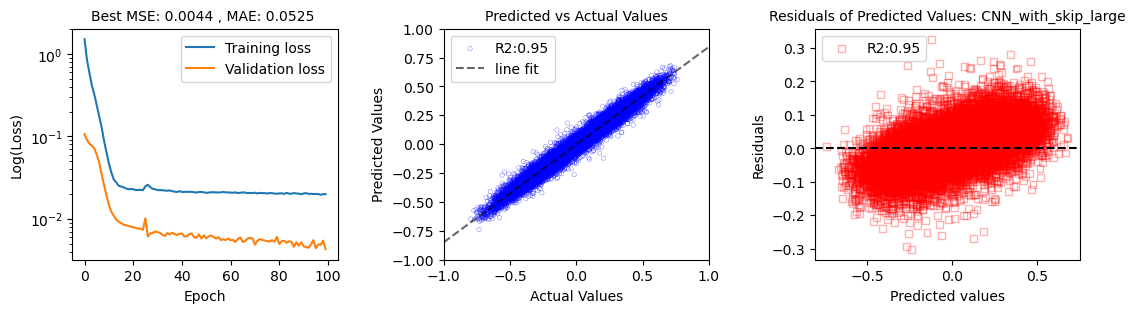

In [36]:
model_evaluate_and_plot(model_lgX13,history_lgX13_1,X_test1,y_test1)

In [38]:
history_lgX13_2 =model_lgX13.fit(X_train3,y_train3,batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[checkpoint])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.1062
Epoch 1: val_loss did not improve from 0.00115
100/100 [==============================] - 27s 271ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.1062 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0356
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1058
Epoch 2: val_loss did not improve from 0.00115
100/100 [==============================] - 29s 293ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1058 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0386
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1056
Epoch 3: val_loss did not improve from 0.00115
100/100 [===

32/32 [==============================] - 3s 85ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0386
Loss: 0.0022083627991378307
Mean Square Error: 0.0022083627991378307
Mean Absolute Error: 0.03859809413552284
32/32 [==============================] - 3s 86ms/step
Test R2 score: 0.97571536830575


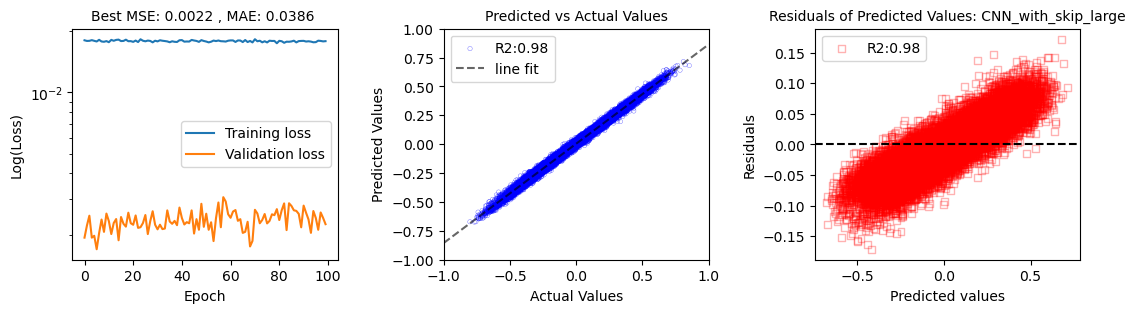

In [39]:
model_evaluate_and_plot(model_lgX13,history_lgX13_2,X_test3,y_test3)